# Criando Modelo para Prever Casos  

<br/>

Agora que já analizamos o dataset, está na hora de criarmos o modelo. Como foi mencionado no outro notebook, vamos tentar prever o número de casos na cidade de São José dos Campos, interiror de São Paulo.

## Importando Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Para formatar os gráficos.
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import ticker

#Modelo que será utilizado.
from fbprophet import Prophet

#Função para visualizar os changepoints no gráfico
#com a predição.
from fbprophet.plot import add_changepoints_to_plot


#Métricas para avaliação do modelo.
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import warnings
warnings.filterwarnings('ignore')


pd.options.display.float_format = "{:,.2f}".format

## Carregando o dataset

In [2]:
df_vale = pd.read_csv('./dados/dados_limpos/vale_do_paraiba.csv')
df_vale.head()

,city,date,epidemiological_week,estimated_population,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,new_confirmed,new_deaths
0,São José dos Campos,2020-03-18,202012,"729,737.00",False,1,0.14,2020-03-18,0.00,0,1,1,0
1,São José dos Campos,2020-03-19,202012,"729,737.00",True,1,0.14,2020-03-18,0.00,0,2,0,0
2,Taubaté,2020-03-19,202012,"317,915.00",False,1,0.31,2020-03-19,0.00,0,1,1,0
3,São José dos Campos,2020-03-20,202012,"729,737.00",False,1,0.14,2020-03-20,0.00,0,3,0,0
4,Taubaté,2020-03-20,202012,"317,915.00",False,1,0.31,2020-03-20,0.00,0,2,0,0


In [3]:
#Convertendo a coluna date para datetime
df_vale['date'] = pd.to_datetime(df_vale['date'], format='%Y-%m-%d')

In [4]:
#filtrando pela cidade de São José dos campos
df_sjc = df_vale.query('city=="São José dos Campos"').reset_index()
df_sjc.drop('index', axis=1, inplace=True)
df_sjc.head()

,city,date,epidemiological_week,estimated_population,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,new_confirmed,new_deaths
0,São José dos Campos,2020-03-18,202012,"729,737.00",False,1,0.14,2020-03-18,0.00,0,1,1,0
1,São José dos Campos,2020-03-19,202012,"729,737.00",True,1,0.14,2020-03-18,0.00,0,2,0,0
2,São José dos Campos,2020-03-20,202012,"729,737.00",False,1,0.14,2020-03-20,0.00,0,3,0,0
3,São José dos Campos,2020-03-21,202012,"729,737.00",True,1,0.14,2020-03-20,0.00,0,4,0,0
4,São José dos Campos,2020-03-22,202013,"729,737.00",True,1,0.14,2020-03-20,0.00,0,5,0,0


O variável alvo que vamos analizar são os novos casos, que está na coluna `new_confirmed`. Vamos plotar essa variável para verificarmos o seu comportamento.

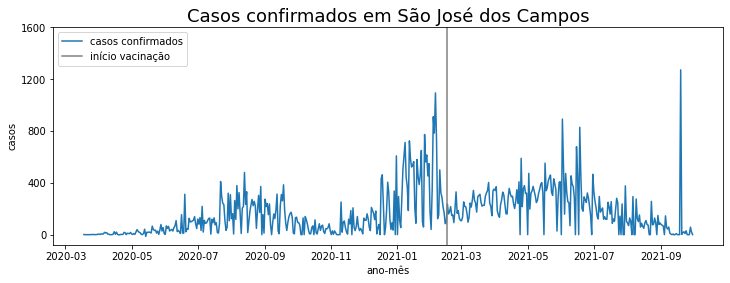

In [5]:
fig, ax = plt.subplots(figsize=(12, 4))

plt.title('Casos confirmados em São José dos Campos', fontsize=18)
plt.plot(df_sjc['date'], df_sjc['new_confirmed'])
plt.axvline(x=pd.to_datetime('2021-02-16'), color='gray')
plt.legend(['casos confirmados', 'início vacinação'], loc='upper left')

ax.yaxis.set_label_text('casos')
ax.yaxis.set_ticks(np.arange(0, 1601, 400))

ax.xaxis.set_label_text('ano-mês')


plt.show()

Adicionei o início da vacinação na cidade para verificarmos o efeito dela sobre os novos casos. Antes da vacinação, o pico de casos tinha cido no final de janeiro e esse pico só foi alcançado no no fim de agosto/21, mas pela variação repentina pode ser um outlier, a verificar.  
Em suma, podemos observar que os casos começam a aumentar considerávelmente em junho/20, o que era esperado dado a época da estação (inverno). Os casos diminuem após setembro/20 e volta a aumentar após Janeiro. A hipótese aqui foi que, devido as festividades o víruos circulou com mais facilidade, mas após um Fevereiro há uma queda. Para o ano de 2021 podemos observar alguns padrões semelhantes, como o pico no inverno, mas com quantidade de casos maiores.

Conforme vimos no gráfico anterior, os casos aumentam considerávelmente após fim de 2020. Vemos no gráfico abaixo a mesma informação, agora verificando a taxa de novos casos, que é obtivo através da diferença da linha posterior menos a atual:

In [6]:
df_sjc['taxa_casos'] = df_sjc['new_confirmed'].diff()
df_sjc.head()

,city,date,epidemiological_week,estimated_population,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,new_confirmed,new_deaths,taxa_casos
0,São José dos Campos,2020-03-18,202012,"729,737.00",False,1,0.14,2020-03-18,0.00,0,1,1,0,NaN
1,São José dos Campos,2020-03-19,202012,"729,737.00",True,1,0.14,2020-03-18,0.00,0,2,0,0,-1.00
2,São José dos Campos,2020-03-20,202012,"729,737.00",False,1,0.14,2020-03-20,0.00,0,3,0,0,0.00
3,São José dos Campos,2020-03-21,202012,"729,737.00",True,1,0.14,2020-03-20,0.00,0,4,0,0,0.00
4,São José dos Campos,2020-03-22,202013,"729,737.00",True,1,0.14,2020-03-20,0.00,0,5,0,0,0.00


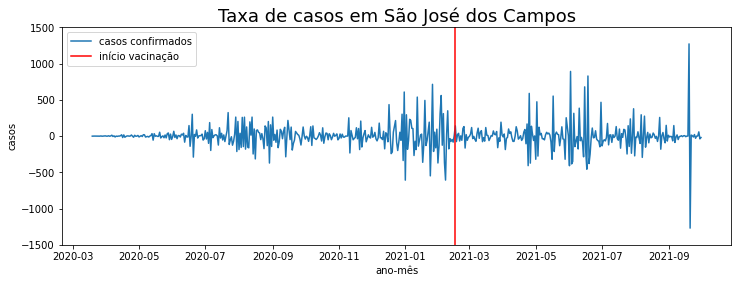

In [7]:
fig, ax = plt.subplots(figsize=(12, 4))

plt.title('Taxa de casos em São José dos Campos', fontsize=18)
plt.plot(df_sjc['date'], df_sjc['taxa_casos'])
plt.axvline(x=pd.to_datetime('2021-02-16'), color='r')
plt.legend(['casos confirmados', 'início vacinação'], loc='upper left')

ax.yaxis.set_label_text('casos')
ax.yaxis.set_ticks(np.arange(-1500, 1501, 500))

ax.xaxis.set_label_text('ano-mês')


plt.show()

## Treinamento do Modelo
### Preparação dos dados
Verificado o comportamento dos dados que vamos modelar, vamos à preparação de dados. Conforme a [documentação](https://facebook.github.io/prophet/docs/quick_start.html#python-api) do Facebook Prophet, o modelo recebe apenas duas colunas, uma contendo a série temporal, como `ds` e a variável álvo, que deve ser chamada de `y`.

In [8]:
df_sjc[['date', 'new_confirmed']]

,date,new_confirmed
0,2020-03-18,1
1,2020-03-19,0
2,2020-03-20,0
3,2020-03-21,0
4,2020-03-22,0
...,...,...
557,2021-09-26,0
558,2021-09-27,0
559,2021-09-28,58
560,2021-09-29,20


In [9]:
df = pd.DataFrame()
df['ds'] = df_sjc['date']
df['y'] = df_sjc['new_confirmed']

df.head()

,ds,y
0,2020-03-18,1
1,2020-03-19,0
2,2020-03-20,0
3,2020-03-21,0
4,2020-03-22,0


In [10]:
df.shape

(562, 2)

### Separando os dados  
Agora precisamos quebrar o dataset em duas partes, uma que servirá para treinar o modelo (500 linhas) e outra para validá-la (62 linhas).

In [11]:
df_train = df[:500]
df_test = df[500:]

O Prophet segue o seguinte fluxo de trabalho:
1. Instanciamos o modelo, com ou sem os parâmetros;
2. Fazemos o treinamento (fit) com os dados de treino;
3. Indicamos a quandidade de período que será predito, através da função `make_future_dataframe`;
4. Realizamos a predição com a função `predict`.

In [12]:
modelo_base = Prophet()
modelo_base.fit(df_train)
data_frame_futuro = modelo_base.make_future_dataframe(periods=62)

previsao = modelo_base.predict(data_frame_futuro)
previsao

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.84808
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       776.784   5.11488e-06       75.6272      0.3389      0.3389      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       776.787   9.46717e-09       77.2584     0.06061           1      187   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-18,-4.38,-140.60,202.21,-4.38,-4.38,39.51,39.51,39.51,39.51,39.51,39.51,0.00,0.00,0.00,35.13
1,2020-03-19,-3.59,-113.01,212.67,-3.59,-3.59,42.96,42.96,42.96,42.96,42.96,42.96,0.00,0.00,0.00,39.37
2,2020-03-20,-2.80,-134.02,226.04,-2.80,-2.80,43.87,43.87,43.87,43.87,43.87,43.87,0.00,0.00,0.00,41.08
3,2020-03-21,-2.00,-164.72,182.79,-2.00,-2.00,6.81,6.81,6.81,6.81,6.81,6.81,0.00,0.00,0.00,4.80
4,2020-03-22,-1.21,-227.61,111.49,-1.21,-1.21,-55.85,-55.85,-55.85,-55.85,-55.85,-55.85,0.00,0.00,0.00,-57.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,2021-09-26,274.56,35.91,391.98,271.78,276.99,-55.85,-55.85,-55.85,-55.85,-55.85,-55.85,0.00,0.00,0.00,218.71
558,2021-09-27,274.59,-5.23,359.77,271.72,277.05,-94.12,-94.12,-94.12,-94.12,-94.12,-94.12,0.00,0.00,0.00,180.47
559,2021-09-28,274.62,117.07,458.02,271.65,277.18,16.82,16.82,16.82,16.82,16.82,16.82,0.00,0.00,0.00,291.45
560,2021-09-29,274.66,122.21,491.04,271.56,277.31,39.51,39.51,39.51,39.51,39.51,39.51,0.00,0.00,0.00,314.17


O modelo já está criado, agora vamos verificar graficamente o que ele previu, junto com os dados reais.

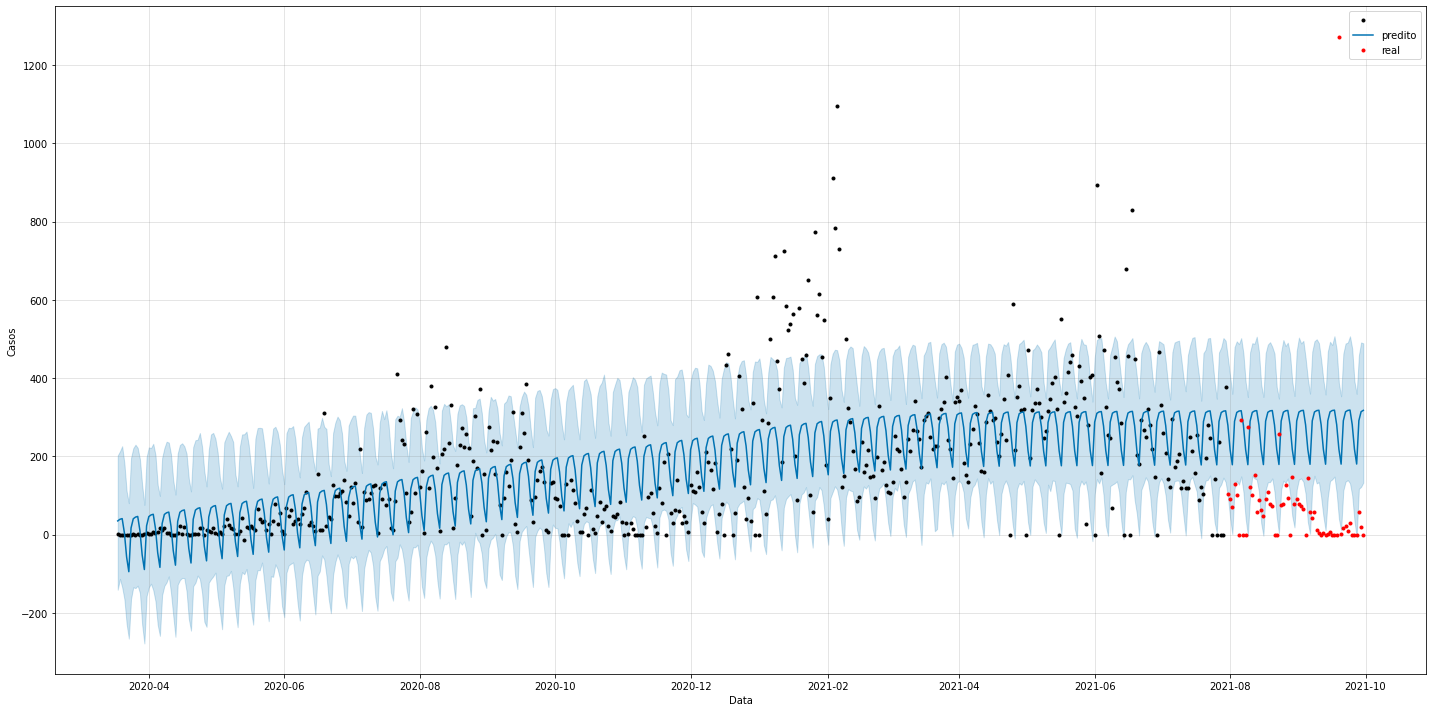

In [13]:
modelo_base.plot(previsao, xlabel='Data', ylabel='Casos', figsize=(20, 10))
plt.plot(df_test['ds'], df_test['y'], '.r')
plt.legend(['', 'predito', 'real'])
plt.show()

A linha em azul são os valores que foi predito pelo modelo, e a "sombra" são representam o intervalo de confiança. Os pontos vermelhos à direita são os valores reais que o modelo tentou predizer. Graficamente vemos que o modelo não conseguiu predizer tão bem os valoes, o modelo mostra uma tendência constante após agosto, quando os dados reais mostrava um declíneo na quantidade de casos.

No gráfico abaixo vemos melhor a tendência através do tempo e a sazonalidade semanal. O primeiro gŕafico indica que que o modelo entendeu que a partir de Feveriro/21 a tendência se manteve constante, e o segundo gráfico explica o quanto do resultado pode ser atribuído à dia da semana a qual o dado pertente. Vemos que no final de semana a importancia cai, o que é natural, haja vista que os nos fins de semanas as secretarias de saúde não funciona, e os casos referentes à esses dias são acumulados durante a semana, como podemos ver o gráfico subindo a partir de terça-feira.

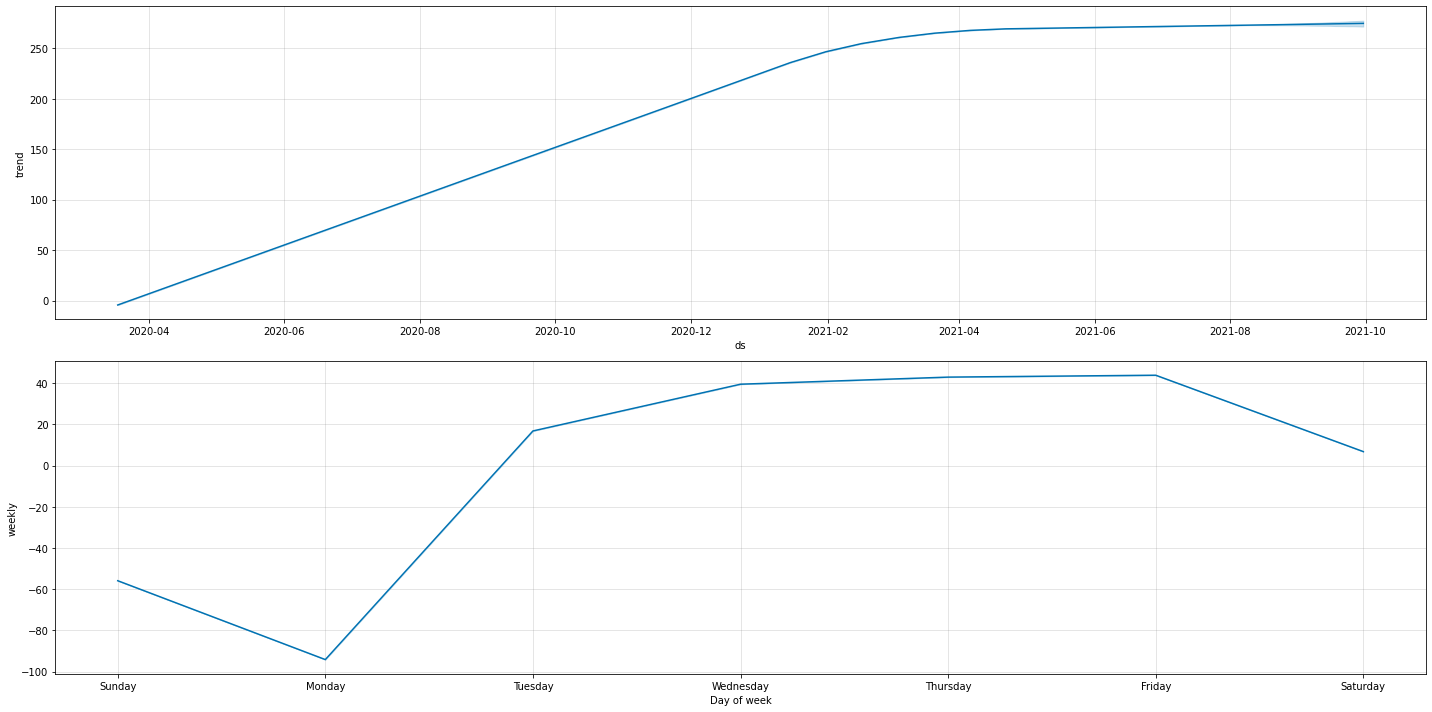

In [14]:
modelo_base.plot_components(previsao, figsize=(20, 10));

Agora que vizualizamos graficamente o que o modelo está predizendo, precisamos utilizar de métricas para avaliar o quão bem o nosso modelo está perfomando. 
Aqui vamos usar três métricas diferentes, sendo elas:
- **Erro Médio Absoluto (MAE)**: Mede a média entre o valor real e o predito, em módulo, por haver números negativos. Como utiliza a mesma escala dos dados que vamos prever é uma métrica fácil de interpretar - Quanto menor o seu valor o seu modelo está performando bem;
- **Raiz do Erro Quadrático Médio (RMSE)**: Derivado do Erro Médio Quadrático, que diferentemente do MAE eleva o resultado ao quadrado - Dessa forma a métrica dá importancia à diferenças maiores. Só que ao elevar ao quadrado a unidade de medida fica distorcida e fica mais difícil interpretar. Para no fim do resultado é aplicado uma raiz quadrada para voltar o resultado na mesma escala - Assim como o MAE, quanto menor o resultado melhor a performance do modelo.
- **Coeficiente de Determinação (R²)** : Representa a variância dos dados que é explicado pelo modelo. Os resultados variam de 0 a 1 e quanto mais próximo de 1 significa que o modelo é mais explicativo em relação aos dados previstos.  

Para saber mais sobre as métricas de regressão, segue uma [sugestão de leitura](https://medium.com/data-hackers/prevendo-n%C3%BAmeros-entendendo-m%C3%A9tricas-de-regress%C3%A3o-35545e011e70) onde Clébio Júnior explica muito bem algumas métricas.

In [15]:
df_performance = pd.DataFrame()

def evaluate_model(model, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    
    return df_performance.append({'model': model, 'mae' : mae, 
                                  'rmse': rmse, 'r2' : r2}, ignore_index=True)

In [16]:
df_performance = evaluate_model('modelo_base', df['y'], previsao['yhat'])
df_performance

,model,mae,rmse,r2
0,modelo_base,111.59,157.40,0.21


Esse primeiro modelo servirá como base para avaliarmos os próximos modelos, realizando os ajustes nos parâmetros.  
Para simplificar a criação, parametrização e treinamento do modelo, vamos criar uma função para automatizar essas etapas.

In [17]:
def build_and_run_prophet_model(df : pd.DataFrame(),  params, prever : int):
    
    #Caso não passe o nenhum parâmetro no dicionário params, 
    #o modelo será criado de forma padrão.
    model = Prophet(**params)
    
    #Adicionando os feriados nacionais, default do modelo.
    model.add_country_holidays(country_name='BR')
    model.fit(df)
    future_ds = model.make_future_dataframe(prever)
    
    previsao = model.predict(future_ds)
    
    return model, previsao

### Tunning do Modelo

Utilizei como referencia o [esse artigo](https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3) para entender os parâmetros e realizar os testes.
    O primeiro parâmetro a ser modificado é o `seasonality_mode`: esse parâmetro indica como a sazonalidade deve ser integrada à sua predição. Ele aceita dois valores, **addtive** e **multiplicative**. O primeiro é ideal quando a sazonalidade dos seus dados são 'contante', ou seja, os valores não variam de um ciclo para o outro, como a temperatura durante o ano. O segundo serve para o segundo caso, quando existe sazonalidade mas os valores variam, como pode ser o caso de valor de uma ação por exemplo.  
Como no nosso caso a ocorrências de novos casos segue uma sazonalidade, mas os valores variam o nosso modelo deve performar melhor se for **multiplicative**.

In [18]:
parametros = {'seasonality_mode' : 'multiplicative'}

modelo2, previsao2 = build_and_run_prophet_model(df_train, parametros, 62)

df_performance = evaluate_model('modelo2', df['y'], previsao2['yhat'])
df_performance

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.84808
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       781.326    0.00075087       71.1423           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       782.122    6.2748e-05       75.6612      0.5879      0.5879      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       782.383   6.84076e-07       82.2298      0.4914      0.4914      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       782.675   1.08148e-05       70.3997           1           1      495   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       782.707   2.65473e-05       78.4525           1           1      620   
    Iter      log prob        ||dx||      ||grad||       alpha  

,model,mae,rmse,r2
0,modelo_base,111.59,157.40,0.21
1,modelo2,106.56,156.00,0.22


O modelo apresentou uma leve melhoria em todas as métricas, então podemos seguir por esse caminho.

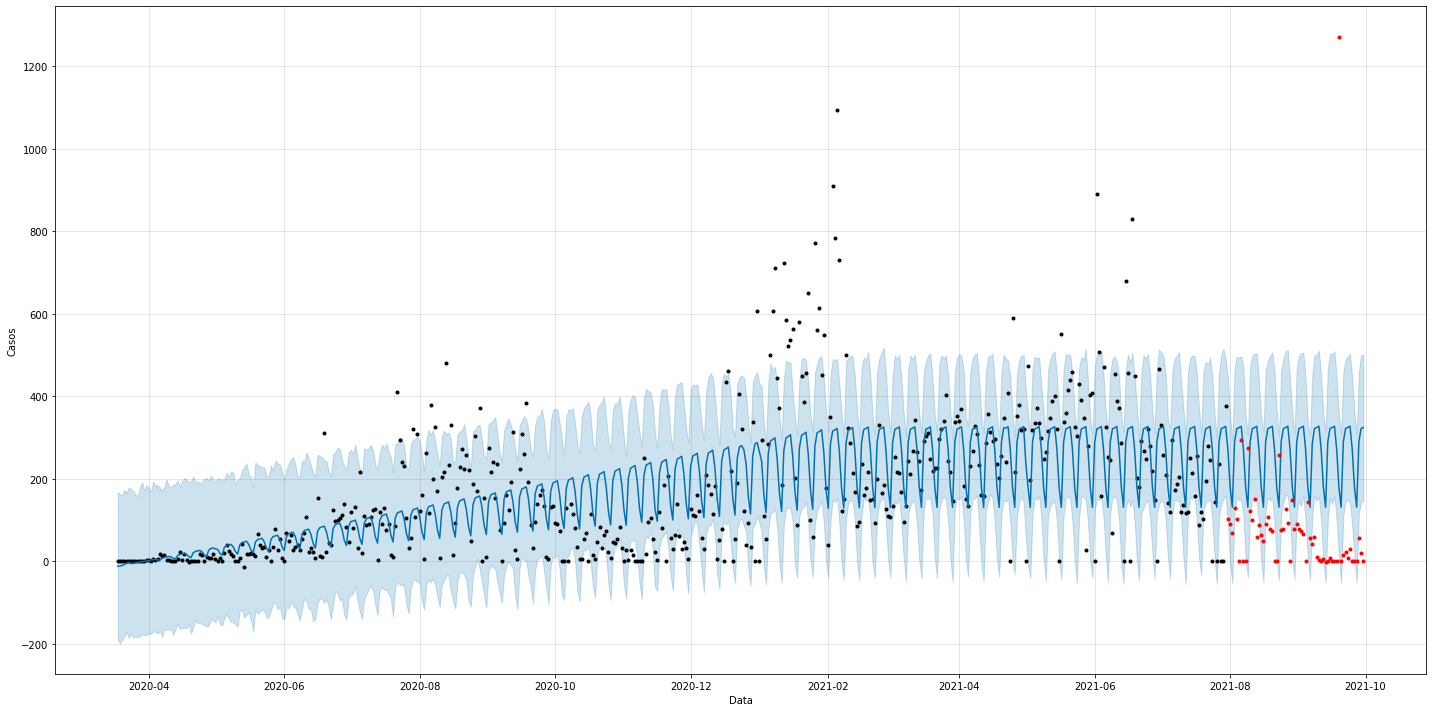

In [19]:
modelo2.plot(previsao2, xlabel='Data', ylabel='Casos', figsize=(20, 10))
plt.plot(df_test['ds'], df_test['y'], '.r')
plt.show()

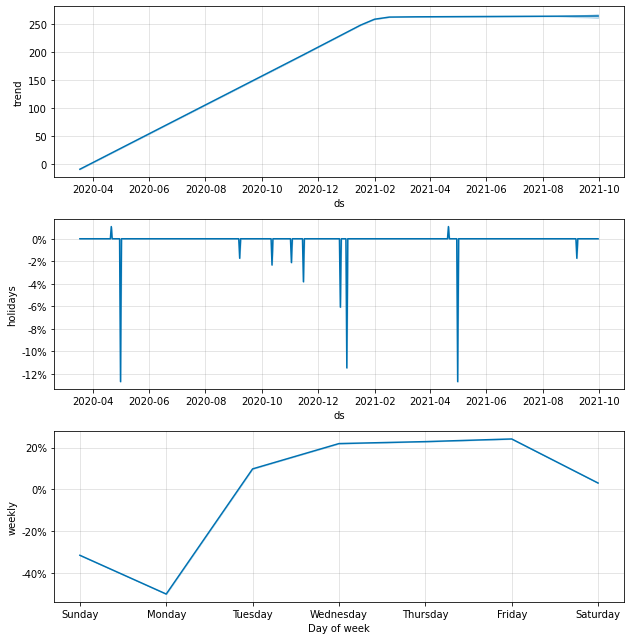

In [20]:
modelo2.plot_components(previsao2);

Vemos no gráfico trend que o modelo ainda entende que houve uma constancia na variável alvo após fevereiro/21, Vamos tratar isso mais para frente.   
Por enquanto vamos verificar novamente a questão dos feriados. Apesar do modelo já ter built-in um calendário de feriados nacionais, ainda precisamos verificar o impacto dos feriados que impactam especificamente a cidade, no casos os feriados estaduais e municipais. Para o próximo modelo vamos passar um novo parâmetro, o `holidays` e ver como o ele se comporta.

In [21]:
#Nota: lista com feriados nacionais inclusos nessa lista,
#o modelo vai sobrescrever.
feriados_sjc = ['2020-01-01', '2020-03-19', '2020-04-10', '2020-04-21',
                '2020-05-01', '2020-05-25', '2020-06-11', '2020-07-09',
                '2020-07-27', '2020-09-07', '2020-10-12', '2020-11-02',
                '2020-11-15', '2020-12-25', '2021-01-01', '2021-03-19',
                '2021-04-02', '2021-04-21', '2021-05-01', '2021-06-03',
                '2021-07-09', '2021-07-27', '2021-09-07', '2021-10-12',
                '2021-11-02', '2021-11-15', '2021-12-25']

feriados = pd.DataFrame({'holiday': 'sjc', 'ds' : pd.to_datetime(feriados_sjc)})
feriados

,holiday,ds
0,sjc,2020-01-01
1,sjc,2020-03-19
2,sjc,2020-04-10
3,sjc,2020-04-21
4,sjc,2020-05-01
5,sjc,2020-05-25
6,sjc,2020-06-11
7,sjc,2020-07-09
8,sjc,2020-07-27
9,sjc,2020-09-07


In [22]:
parametros = {'seasonality_mode': 'multiplicative', 'holidays' : feriados}

modelo3, previsao3 = build_and_run_prophet_model(df_train, parametros, 62)
df_performance = evaluate_model('modelo3', df['y'], previsao3['yhat'])
df_performance

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.84808
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       784.048   0.000893415       85.6662       0.562       0.562      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       784.274   3.24029e-08       70.9137      0.2852           1      252   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


,model,mae,rmse,r2
0,modelo_base,111.59,157.40,0.21
1,modelo2,106.56,156.00,0.22
2,modelo3,105.34,154.30,0.24


O modelo teve uma ligeira melhora ao adicionar os feriados específicos, vamos manter esse parâmetro nos próximos modelos para ver como se comporta.

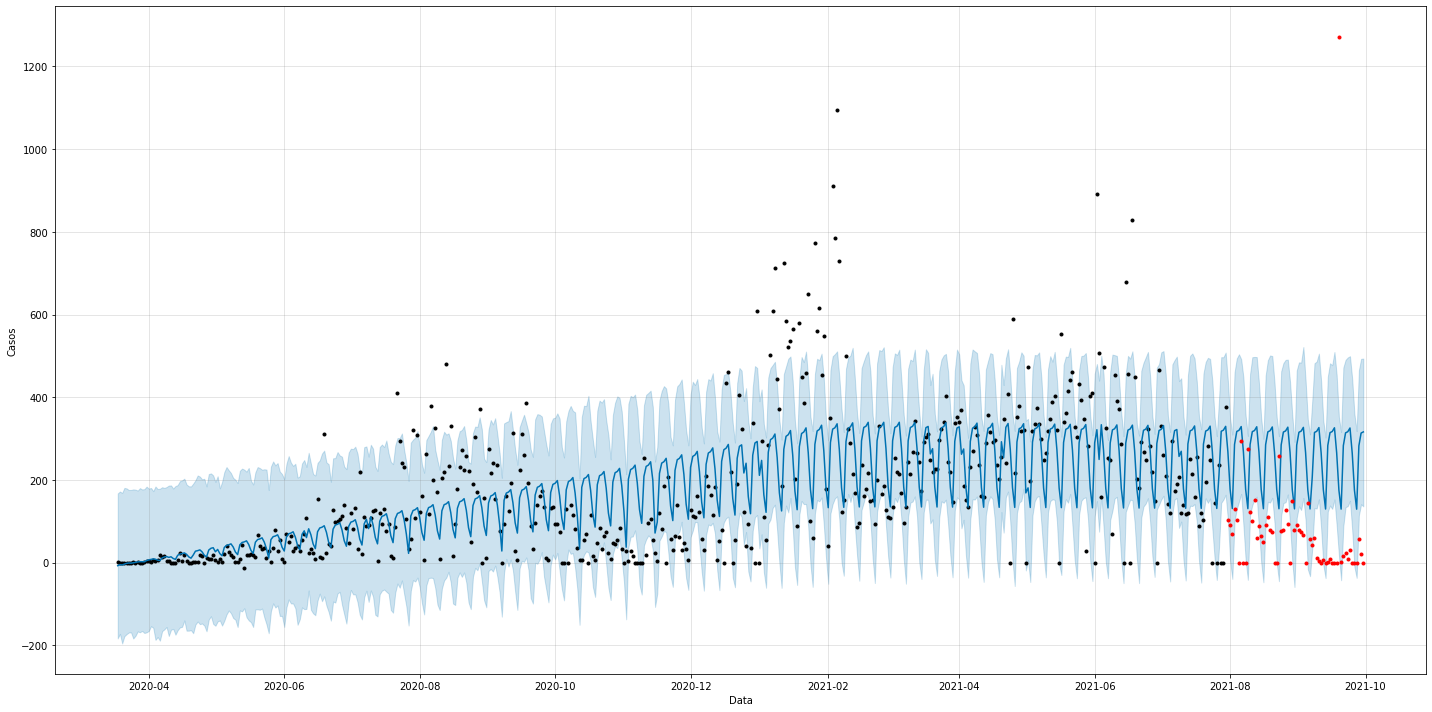

In [23]:
modelo3.plot(previsao3, xlabel='Data', ylabel='Casos', figsize=(20, 10))
plt.plot(df_test['ds'], df_test['y'], '.r')
plt.show()

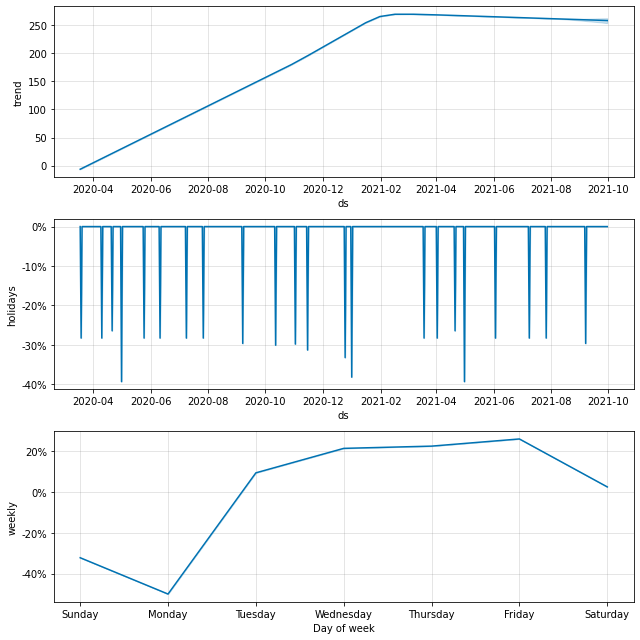

In [24]:
modelo3.plot_components(previsao3);

Vemos agora o gráfico de tendência apresentar uma leve queda, o que pode ser um indício de que estamos chegando ao resultado desejado.  
O próximo parâmetro a ser mexido é o `n_changepoints`. Esse parâmetro especifica quantos pontos de mudanças o modelo terá (por padrão ele considera 25 pontos). Quanto mais pontos tiverem o modelo encontrá mais pontos onde a tendência muda, mas em contrapartida  levará mais tempo para o modelo ser treinado, sem que haja garantia de melhora no resultado.  
Vamos criar dois modelos turnado esse parâmetro, uma com 100 e outra com 200 para verificarmos o resultado.

In [25]:
parametros = {'seasonality_mode': 'multiplicative','holidays' : feriados, 'n_changepoints' : 100}

modelo4, previsao4 = build_and_run_prophet_model(df_train, parametros, 62)

df_performance = evaluate_model('modelo4', df['y'], previsao4['yhat'])
df_performance

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.84808
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        781.67   0.000366267       157.848      0.8407      0.8407      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        783.07   0.000641757       163.604      0.5996      0.5996      215   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       783.216   3.41376e-05       154.722           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     342       783.224   1.34351e-08       154.968      0.3901           1      378   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


,model,mae,rmse,r2
0,modelo_base,111.59,157.40,0.21
1,modelo2,106.56,156.00,0.22
2,modelo3,105.34,154.30,0.24
3,modelo4,105.27,154.22,0.24


In [26]:
parametros = {'seasonality_mode': 'multiplicative','holidays' : feriados, 'n_changepoints' : 200}

modelo5, previsao5 = build_and_run_prophet_model(df_train, parametros, 62)

df_performance = evaluate_model('modelo5', df['y'], previsao5['yhat'])
df_performance

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.84808
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       781.715   5.13679e-05       180.175           1           1      107   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        782.28   2.47045e-06       212.744      0.7516      0.7516      208   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       782.553   0.000179937        224.67           1           1      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       782.701   8.00021e-05       235.943           1           1      416   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        782.94   0.000106132         212.3      0.8569      0.8569      520   
    Iter      log prob        ||dx||      ||grad||       alpha  

,model,mae,rmse,r2
0,modelo_base,111.59,157.40,0.21
1,modelo2,106.56,156.00,0.22
2,modelo3,105.34,154.30,0.24
3,modelo4,105.27,154.22,0.24
4,modelo5,105.68,154.77,0.23


Vemos que nem sempre um número maior de pontes resultará em resultados melhores, naturalmente para achar um ponto ideal preciaríamos testar mais opções.
Para ilustrar melhor a diferença na tunagem desse parametro, veja no gráfico abaixo as linhas verticais vermelhas que o modelo determinou. Esse é o próximo problema que vamos atacar. O modelo agrupou praticamente todo os pontos de mudança numa faixa de data, indicando que o modelo ainda não está flexível para identiciar tendências.

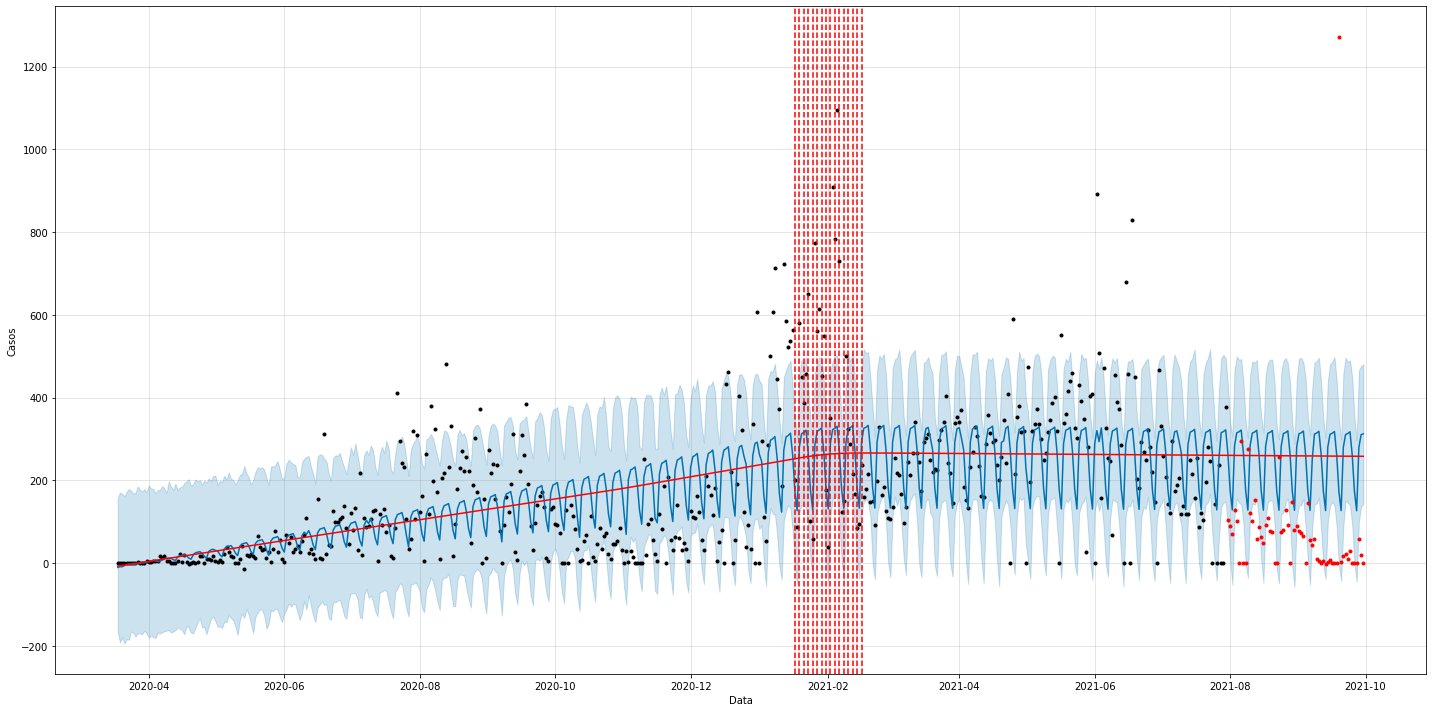

In [27]:
fig = modelo5.plot(previsao4, xlabel='Data', ylabel='Casos', figsize=(20, 10))
a = add_changepoints_to_plot(fig.gca(), modelo5, previsao5)
plt.plot(df_test['ds'], df_test['y'], '.r')
plt.show()

O próximo parâmetro a ser tunado é o `changepoint_prior_scale`, e ele deve ter o maior impacto dentre todos os que testamos até agora. Basicamente ele determina a "flexibilidade" do da linha de tendência sob o ponto de mudança. O valor default é 0.05, o que pode servir para a maioria dos casos, mas conforme indicado na própria [documentação](https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning) do Prophet, um range entre 0.001 a 0.5 funcionar. Vamos utilizar o valor de **0.50** e verificar o resultado.

In [28]:
parametros = {'seasonality_mode': 'multiplicative', 'holidays' : feriados, 'n_changepoints': 100, 
              'changepoint_prior_scale' : 0.50}

modelo_final, previsao_final = build_and_run_prophet_model(df_train, parametros, 62)
df_performance = evaluate_model('modelo_final', df['y'], previsao_final['yhat'])
df_performance

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.84808
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       847.798     0.0281851       196.903      0.2349     0.02349      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       863.485     0.0335011        121.83      0.1447           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       867.233    0.00732426       60.0716           1           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       868.859    0.00324913       28.5601           1           1      496   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        869.98    0.00741129       22.3368           1           1      613   
    Iter      log prob        ||dx||      ||grad||       alpha  

,model,mae,rmse,r2
0,modelo_base,111.59,157.40,0.21
1,modelo2,106.56,156.00,0.22
2,modelo3,105.34,154.30,0.24
3,modelo4,105.27,154.22,0.24
4,modelo5,105.68,154.77,0.23
5,modelo_final,74.09,119.65,0.54


E o resultado foi drásticamente melhor!  

Vejamos graficamente como o nosso modelo se comporta:

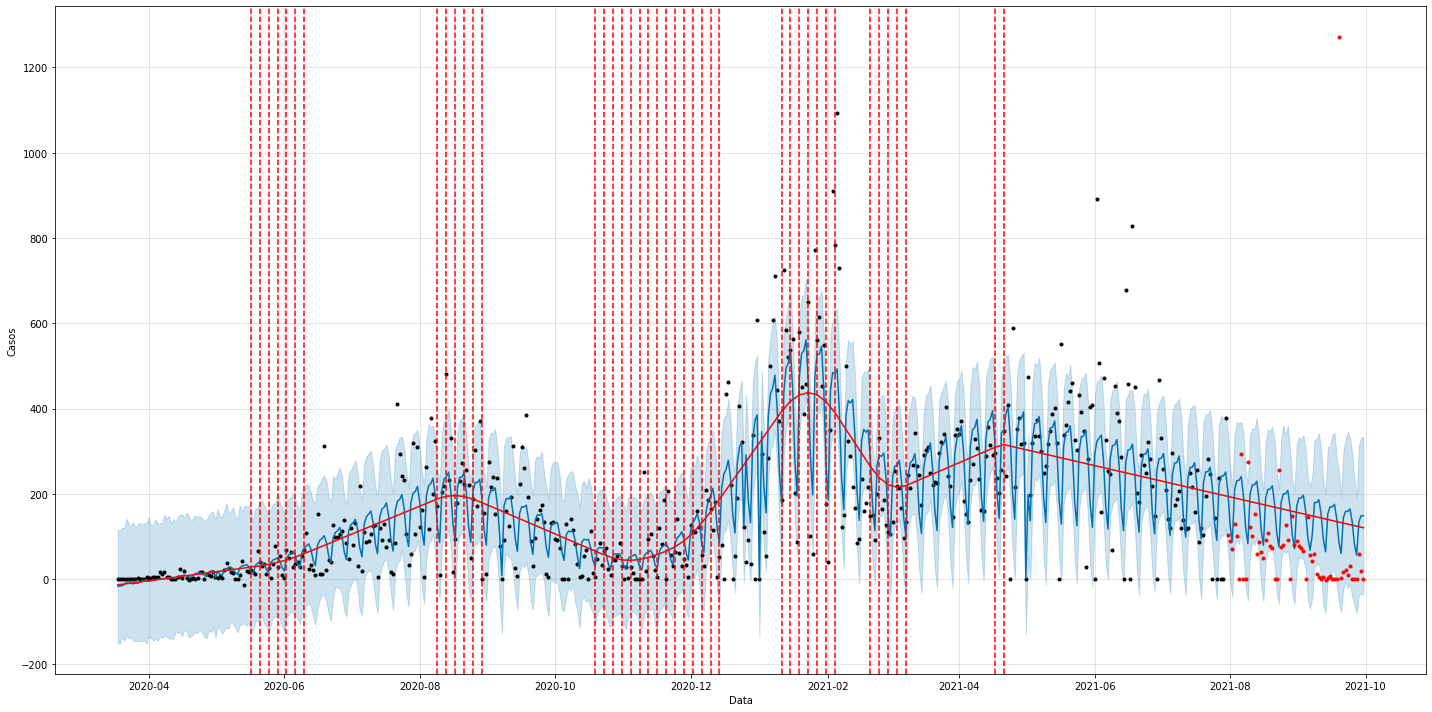

In [29]:
fig = modelo_final.plot(previsao_final, xlabel='Data', ylabel='Casos', figsize=(20, 10))
a = add_changepoints_to_plot(fig.gca(), modelo_final, previsao_final)
plt.plot(df_test['ds'], df_test['y'], '.r')
plt.show()

Agora os change points estão mais distribuídos ao longo da série, e ele acompanha melhor a tendência dos dados, como podemos ver tamném nos gráfico abaixo. Visualizando o gráfico sinto que ainda podia melhorar, pois vemos que em junho/21 a tendência ainda era de alta, mas o modelo assumiu a queda, mas de um modeo geral o desempenho do modelo é satisfatório.

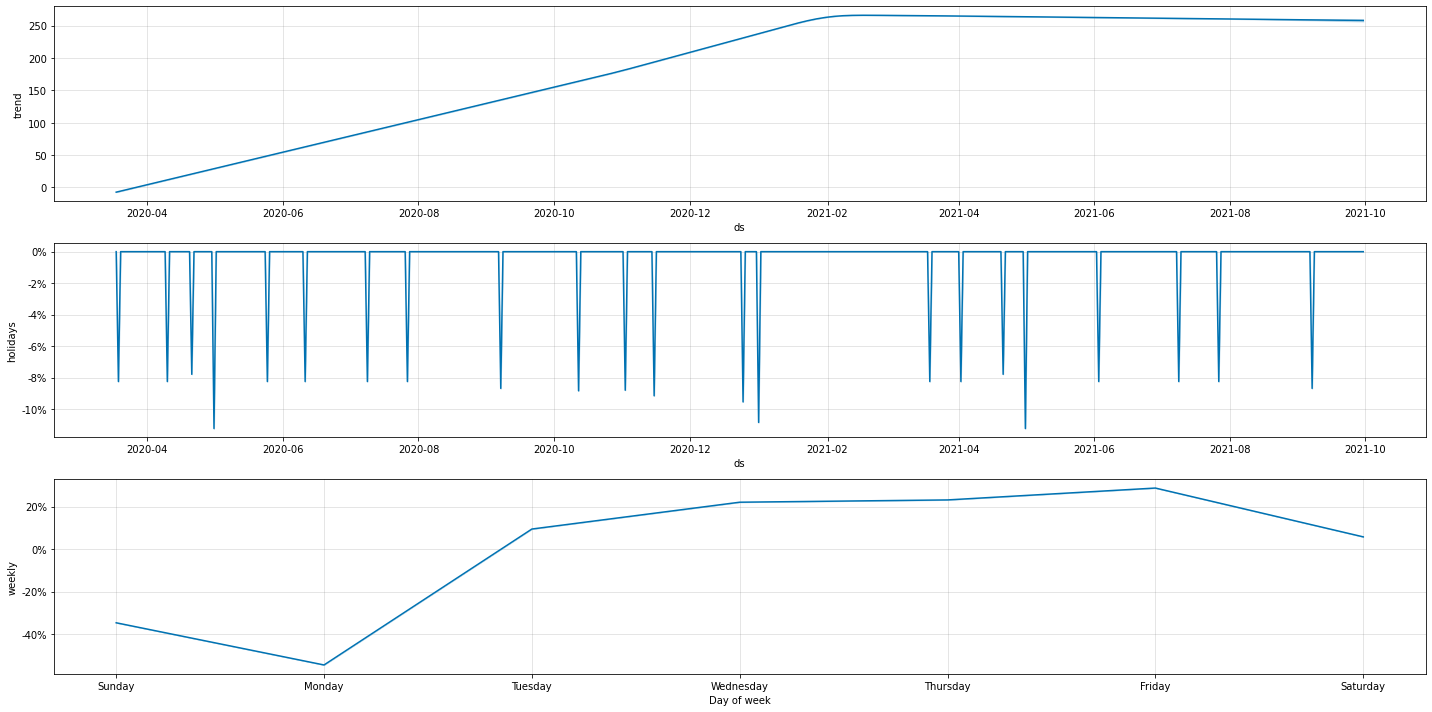

In [30]:
modelo_final.plot_components(previsao5, figsize=(20, 10));

## Conclusão  
Através do desenvolvimento do modelo para predição de novos casos, foi possível explorar vários parâmetros e descobrir como melhorar a performance. O desempenho do modelo final ainda pode ser melhorado, ao analisar os outliers e normalizar os dados.  
Porém vale chamar atenção novamente para o problema de consistência dos dados. No Brasili já é sabido desde o início da pandemia que não possui capacidade de testagem e acompanhamento adequado, e gestão dos dos dados adequados, o que dificulta o trabalho de desenvolvimento de modelos como esse.

In [31]:
#Salvar o dataframe com o desempenho dos modelos.
df_performance.to_csv('./dados/dados_limpos/performance.csv', index=False)